 # ML for Environmental Engineering 
 By: Suheyla Tozan and Steven Gutterman

## Module Import

In [1]:
!pip install openpyxl
!pip install tensorflow
!pip install hyperopt
!pip install pandas
!pip install matplotlib
!pip install xarray
!pip install seaborn
!pip install scikit-learn
!pip install utils
!pip install keras
!pip install --upgrade tensorflow

In [2]:
!pip install xgboost==1.7.6


In [3]:
!pip install keras-tuner

In [4]:
# Import Modules
import os
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import xgboost as xgb
print("xgboost version = ",xgb.__version__)

from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from utils import *

xgboost version =  2.0.2


## Data Processing

/var/folders/93/5t7_3xxn2dvdtnjj99wxz2wc0000gn/T/ipykernel_41189/970045046.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.loc[:, 'wind speed'].fillna(df_new['wind speed'].mean(), inplace=True)
/var/folders/93/5t7_3xxn2dvdtnjj99wxz2wc0000gn/T/ipykernel_41189/970045046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.loc[:, 'wind direction'].fillna(df_new['wind direction'].mean(), inplace=True)
/var/folders/93/5t7_3xxn2dvdtnjj99wxz2wc0000gn/T/ipykernel_41189/970045046.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documenta

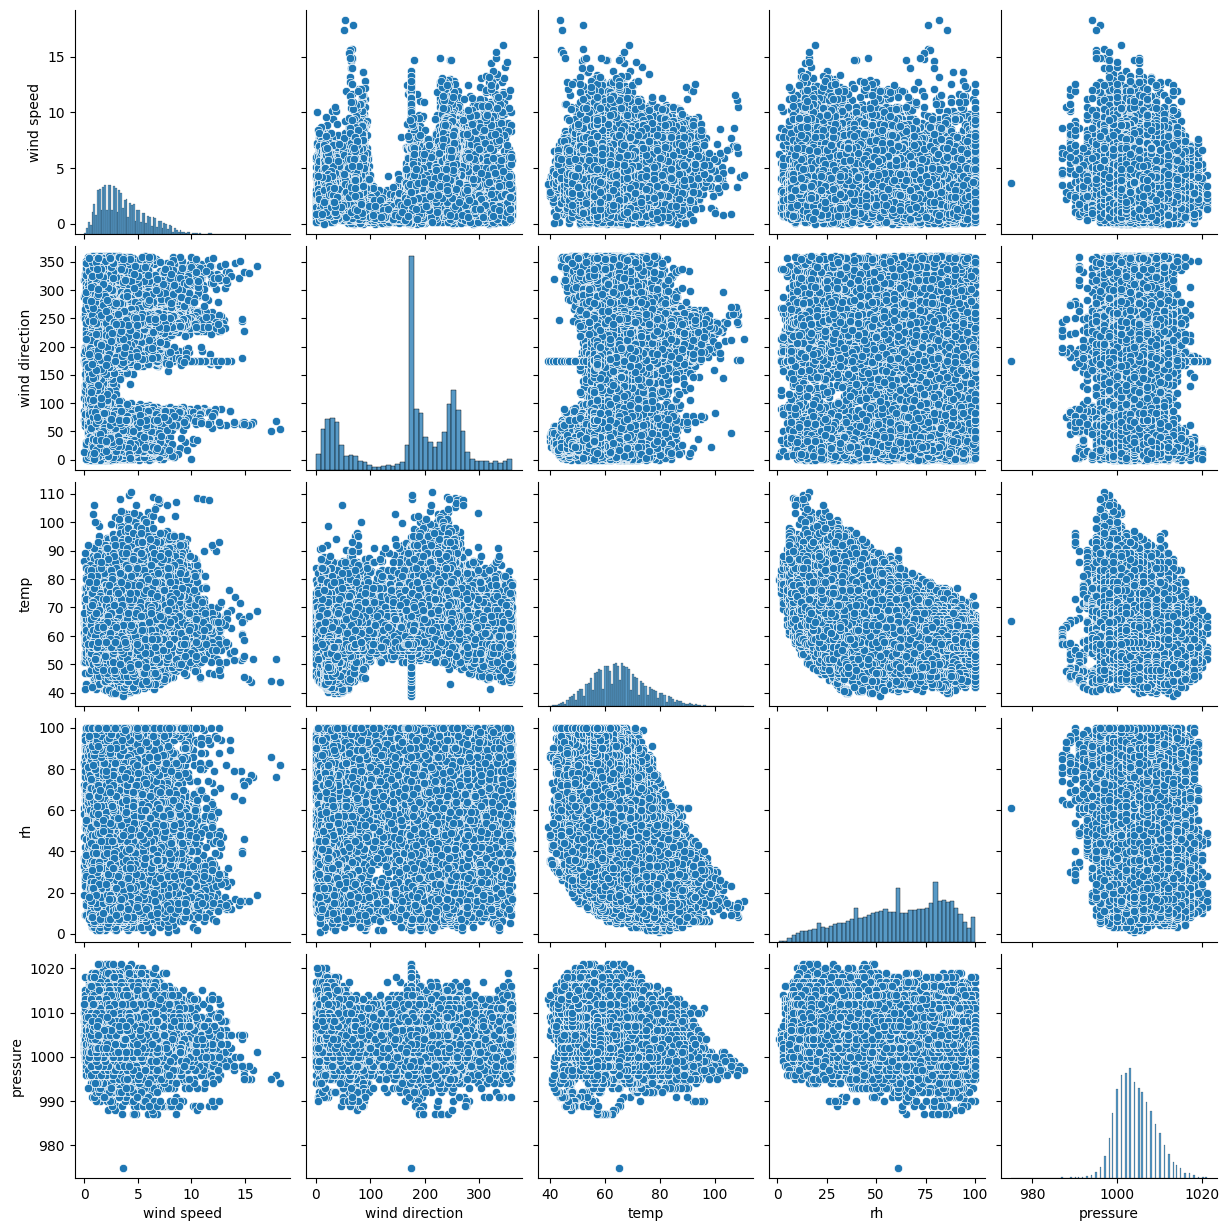

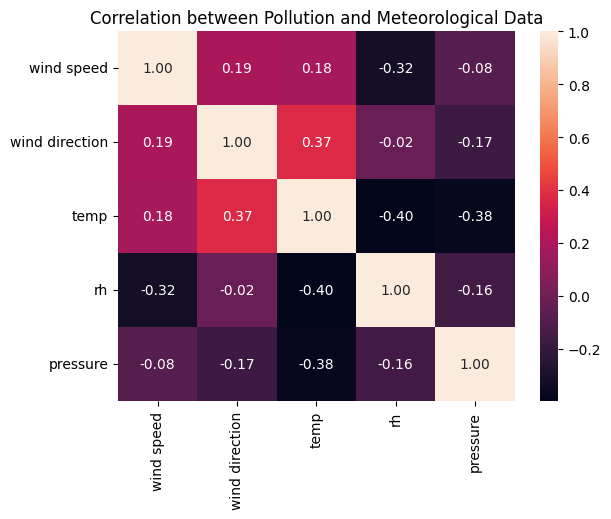

In [5]:
# 1. Data Processing: Prepare Data for Training & Testing

df = pd.read_excel("Data/metdata_2018-2023_ELABHWC.xlsx") #meterological data
df2 = pd.read_excel("Data/criteriagasdata_2018-2023_ELABHWC.xlsx") #air quality data


merged_df = pd.merge(df, df2, on=['date_gmt', 'time_gmt'], how='inner')
desired_columns = ['date_gmt', 'time_gmt', 'wind speed', 'wind direction', 'temp', 'rh', 'pressure', 'CO', 'NO2', 'SO2','O3','PM10']
final_df = merged_df[desired_columns]
co_original = final_df['CO']
no2_original = final_df['NO2']
so2_original = final_df['SO2']
o3_original = final_df['O3']
#Get rid of all predictand data that is 'NaN'
df_new = final_df.dropna(subset=['CO', 'NO2', 'SO2','O3'])

df_new.loc[:, 'wind speed'].fillna(df_new['wind speed'].mean(), inplace=True)
df_new.loc[:, 'wind direction'].fillna(df_new['wind direction'].mean(), inplace=True)
df_new.loc[:, 'temp'].fillna(df_new['temp'].mean(), inplace=True)
df_new.loc[:, 'rh'].fillna(df_new['rh'].mean(), inplace=True)
df_new.loc[:, 'pressure'].fillna(df_new['pressure'].mean(), inplace=True)

X_features = df_new[['wind speed', 'wind direction', 'temp', 'rh', 'pressure','date_gmt']]
y_co = df_new['CO']
y_no2 = df_new['NO2']
y_so2 = df_new['SO2']
y_o3 = df_new['O3']

#Pairplot
df_cor = df_new.drop(['date_gmt', 'time_gmt'], axis=1)
features = ['wind speed', 'wind direction', 'temp','rh','pressure']
subset_corr = df_cor[features]
sns.pairplot(subset_corr)
#plt.savefig("pairplot.png")
plt.show()

#Heatmap
df_cor = df_new.drop(['date_gmt', 'time_gmt'], axis=1)
features = ['wind speed', 'wind direction', 'temp','rh','pressure']
subset_corr = df_cor[features]
correlation_matrix = subset_corr.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title("Correlation between Pollution and Meteorological Data")
#plt.savefig("heatmap.png")
plt.show()


#Determine Train and Test Data

#CO
X_train_co,X_test_co,y_train_co,y_test_co = train_test_split(X_features, y_co, test_size = 0.30, random_state = 512)
X_train_co = X_train_co[['wind speed', 'wind direction', 'temp', 'rh', 'pressure']]
time_test_co = X_test_co['date_gmt']
X_test_co = X_test_co [['wind speed', 'wind direction', 'temp', 'rh', 'pressure']]

#NO2
X_train_no2,X_test_no2,y_train_no2,y_test_no2 = train_test_split(X_features, y_no2, test_size = 0.30, random_state = 512)
X_train_no2 = X_train_no2[['wind speed', 'wind direction', 'temp', 'rh', 'pressure']]
time_test_no2 = X_test_no2['date_gmt']
X_test_no2 = X_test_no2 [['wind speed', 'wind direction', 'temp', 'rh', 'pressure']]

#SO2
X_train_so2,X_test_so2,y_train_so2,y_test_so2 = train_test_split(X_features, y_so2, test_size = 0.30, random_state = 512)
X_train_so2 = X_train_so2[['wind speed', 'wind direction', 'temp', 'rh', 'pressure']]
time_test_so2 = X_test_so2['date_gmt']
X_test_so2 = X_test_so2[['wind speed', 'wind direction', 'temp', 'rh', 'pressure']]

#O3
X_train_o3,X_test_o3,y_train_o3,y_test_o3 = train_test_split(X_features, y_o3, test_size = 0.30, random_state = 512)
X_train_o3 = X_train_o3[['wind speed', 'wind direction', 'temp', 'rh', 'pressure']]
time_test_o3 = X_test_o3['date_gmt']
X_test_o3 = X_test_o3[['wind speed', 'wind direction', 'temp', 'rh', 'pressure']]


# Standardization
mean_co, std_co = X_train_co.mean(), X_train_co.std()
mean_no2, std_no2 = X_train_no2.mean(), X_train_no2.std()
mean_so2, std_so2 = X_train_so2.mean(), X_train_so2.std()
mean_o3, std_o3 = X_train_o3.mean(), X_train_o3.std()

#CO
X_train_co = (X_train_co - mean_co)/std_co
X_test_co = (X_test_co - mean_co)/std_co
#NO2
X_train_no2 = (X_train_no2 - mean_no2)/std_no2
X_test_no2 = (X_test_no2 - mean_no2)/std_no2
#SO2
X_train_so2 = (X_train_so2 - mean_so2)/std_so2
X_test_so2 = (X_test_so2 - mean_so2)/std_so2
#O3
X_train_o3 = (X_train_o3 - mean_o3)/std_o3
X_test_o3 = (X_test_o3 - mean_o3)/std_o3

X_train_fi_co = pd.DataFrame(X_train_co, columns=features)
X_train_co = X_train_co.to_numpy()
y_train_co = y_train_co.to_numpy()
X_test_co = X_test_co.to_numpy()

X_train_fi_no2 = pd.DataFrame(X_train_no2, columns=features)
X_train_no2 = X_train_no2.to_numpy()
y_train_no2 = y_train_no2.to_numpy()
X_test_no2 = X_test_no2.to_numpy()

X_train_fi_so2 = pd.DataFrame(X_train_so2, columns=features)
X_train_so2 = X_train_so2.to_numpy()
y_train_so2 = y_train_so2.to_numpy()
X_test_so2 = X_test_so2.to_numpy()

X_train_fi_o3 = pd.DataFrame(X_train_o3, columns=features)
X_train_o3 = X_train_o3.to_numpy()
y_train_o3 = y_train_o3.to_numpy()
X_test_o3 = X_test_o3.to_numpy()

## Function for Model Evaluation

In [6]:
#Feature Importance
# The code below was retained from the following website with slight modifications: 
#https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html

def plot_feature_importance(importance,names, model, gas):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(6,6))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(f'{model}: {gas} Concentration Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

#Prediction Error Histogram
def prediction_error(outcome, input, model, gas):
    errors = outcome - input
    plt.hist(errors, bins=30, edgecolor='black', alpha=0.5)
    plt.title(f'{model}: {gas} Concentration Model Evlaution')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')

## Keras Tuner

Trial 30 Complete [00h 00m 04s]
val_loss: 0.055413320660591125

Best val_loss So Far: 0.03904289752244949
Total elapsed time: 00h 01m 05s

The optimal number of neurons is 64 and the optimal learning rate 
is 0.005. Best activation is relu and the best amount of layers is 4 along with the best minibatch being 
64 With that, the best number of epochs is 50.



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 128)               768       
                                                                 
 hidden_layer_2 (Dense)      (None, 128)               16512     
                                                                 
 hidden_layer_3 (Dense)      (None, 128)               16512     
                                                                 
 hidden_layer_4 (Dense)      (None, 128)               16512     
                                                                 
 hidden_layer_5 (Dense)      (None, 128)               16512     
                                                                 
 hidden_layer_6 (Dense)      (None, 128)               16512     
                                                                 
 hidden_layer_7 (Dense)      (None, 128)              

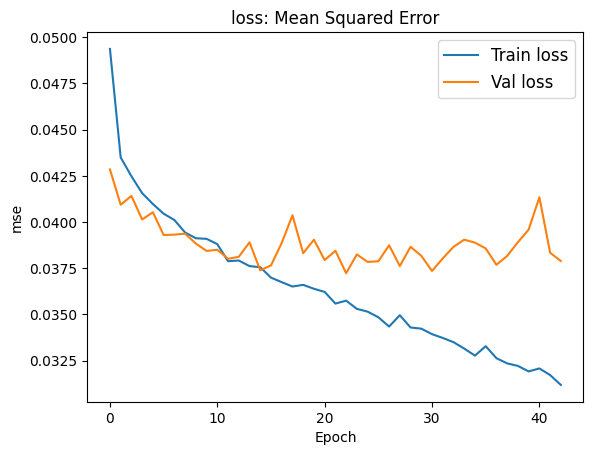

In [7]:
# Hyperparamter tunning using Keras 
# For this section, we attempted to use Keras Tuner to tune the hyperparamters for CO predications. It was found that the tuner was overfitting
# and manual tuning produced better results. Therefore, this seciton was ommitted for CO predictions.

#CO
hyperparameters = {
    'n_neuron' : [32, 64, 128],
    'activation' : ['relu','linear','tanh'],
    'num_epochs' : [10, 50, 100],
    'learning_rate' : [0.001, 0.005, 0.01],
    'minibatch_size' : [32,64],
    'N_layers' : [2, 4, 6, 8]
}

def create_model(hp):
    model = Sequential()
    # Hyperparameters
    n_neuron = hp.Choice('units', [32, 64, 128])
    activation = hp.Choice('activation', ['relu', 'linear', 'tanh'])
    N_layers = hp.Int('N_layers', min_value=2, max_value=8, step=2)
    learning_rate = hp.Choice('learning_rate', [0.001, 0.005, 0.01])
    minibatch_size = hp.Choice('minibatch_size', [32, 64])
    num_epochs = hp.Choice('num_epochs', [10, 50, 100])
    # Input layer
    model.add(Dense(n_neuron, activation=activation, name="hidden_layer_1", input_shape=(X_train_co.shape[1],)))
    # Hidden layers
    for n in range(1, N_layers):
        model.add(Dense(n_neuron, activation=activation, name=f"hidden_layer_{n + 1}"))
    # Output layer
    model.add(Dense(1, activation='linear', name="output_layer"))
    # Compile the model
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    return model
    
import keras_tuner as kt
tuner = kt.Hyperband(create_model,
                    objective='val_loss',
                    max_epochs=10,
                    factor=3,
                    project_name='NN_tun_CO')
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
tuner.search(X_train_co, y_train_co, epochs=50, validation_split=0.2, callbacks=[early_stop])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of neurons is {best_hps.get('units')} and the optimal learning rate 
is {best_hps.get('learning_rate')}. Best activation is {best_hps.get('activation')} and the best amount of layers is {best_hps.get('N_layers')} along with the best minibatch being 
{best_hps.get('minibatch_size')} With that, the best number of epochs is {best_hps.get('num_epochs')}.
""")

# set hyperparameters
n_neuron       = 128
activation     = 'relu' #linear', 'tanh', def my_leaky_relu(x): return tf.nn.leaky_relu(x, alpha=0.01)
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64
N_layers       = 8

# Build a neural network from scratch
model = Sequential()
model.add(Dense(n_neuron,  activation=activation, name="hidden_layer_1" ,input_shape=(X_train_co.shape[1],)))
for n in range(N_layers-1):
    model.add(Dense(n_neuron,  activation=activation, name="hidden_layer_"+str(n+2))) 
model.add(Dense(1,  activation='linear', name="output_layer")) # the output layer
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
model.summary()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = model.fit(X_train_co, y_train_co, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])

plt.plot()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss: Mean Squared Error', fontsize=12)
plt.ylabel('mse')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=12)
#plt.savefig("NNCO1.png")

y_test_pre_co2_tun = model.predict(X_test_co)

# evaluate the predictions
mse_co = mean_squared_error(y_test_co, y_test_pre_co2_tun)
print("Mean Squared Error:", mse_co)

mae_co = mean_absolute_error(y_test_co, y_test_pre_co2_tun)
print(f"Mean Absolute Error: {mae_co}")

rmse_co = mean_squared_error(y_test_co, y_test_pre_co2_tun, squared=False)
print(f"Root Mean Squared Error: {rmse_co}")


Trial 30 Complete [00h 00m 04s]
val_loss: 67.05974578857422

Best val_loss So Far: 63.219608306884766
Total elapsed time: 00h 01m 30s

The optimal number of neurons is 128 and the optimal learning rate 
is 0.001. Best activation is tanh and the best amount of layers is 4 along with the best minibatch being 
64 With that, the best number of epochs is 60.



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 128)               768       
                                                                 
 hidden_layer_2 (Dense)      (None, 128)               16512     
                                                                 
 hidden_layer_3 (Dense)      (None, 128)               16512     
                                                                 
 hidden_layer_4 (Dense)      (None, 128)               16512     
                                                                 
 hidden_layer_5 (Dense)      (None, 128)               16512     
                                                                 
 hidden_layer_6 (Dense)      (None, 128)               16512     
                                                                 
 output_layer (Dense)        (None, 1)                

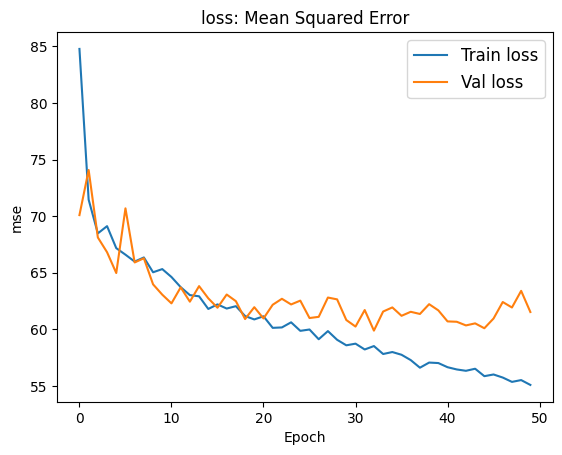

In [34]:
# Hyperparamter tunning using Keras 
# For this section, we attempted to use Keras Tuner to tune the hyperparamters for NO2 predications. The method produced results that seemed
# to overfit so manual tuning was done with an inital starting point being from the Keras Tuner.

#NO2
hyperparameters = {
    'n_neuron' : [32, 64, 128],
    'activation' : ['relu','linear','tanh'],
    'learning_rate' : [0.001, 0.005, 0.01, 0.1],
    'minibatch_size' : [32,64],
    'N_layers' : [2, 4, 6]
}

def create_model(hp):
    model = Sequential()
    # Hyperparameters
    n_neuron = hp.Choice('units', [32, 64, 128])
    activation = hp.Choice('activation', ['relu', 'linear', 'tanh'])
    N_layers = hp.Int('N_layers', min_value=2, max_value=8, step=2)
    learning_rate = hp.Choice('learning_rate', [0.001, 0.005, 0.01])
    minibatch_size = hp.Choice('minibatch_size', [32, 64])
    num_epochs = hp.Int('num_epochs', min_value=40, max_value=100, step=10)
    # Input layer
    model.add(Dense(n_neuron, activation=activation, name="hidden_layer_1", input_shape=(X_train_no2.shape[1],)))
    # Hidden layers
    for n in range(1, N_layers):
        model.add(Dense(n_neuron, activation=activation, name=f"hidden_layer_{n + 1}"))
    # Output layer
    model.add(Dense(1, activation='linear', name="output_layer"))
    # Compile the model
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    return model
    
import keras_tuner as kt
tuner = kt.Hyperband(create_model,
                    objective='val_loss',
                    max_epochs=10,
                    factor=3,
                    project_name='NN_tun_NO2')
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
tuner.search(X_train_no2, y_train_no2, epochs=50, validation_split=0.2, callbacks=[early_stop])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of neurons is {best_hps.get('units')} and the optimal learning rate 
is {best_hps.get('learning_rate')}. Best activation is {best_hps.get('activation')} and the best amount of layers is {best_hps.get('N_layers')} along with the best minibatch being 
{best_hps.get('minibatch_size')} With that, the best number of epochs is {best_hps.get('num_epochs')}.
""")

# # set hyperparameters
n_neuron       = 128
activation     = 'relu' #linear', 'tanh', def my_leaky_relu(x): return tf.nn.leaky_relu(x, alpha=0.01)
num_epochs     = 50
learning_rate  = 0.005
minibatch_size = 64
N_layers       = 6

#Build a neural network from scratch
model = Sequential()
model.add(Dense(n_neuron,  activation=activation, name="hidden_layer_1" ,input_shape=(X_train_no2.shape[1],)))
for n in range(N_layers-1):
    model.add(Dense(n_neuron,  activation=activation, name="hidden_layer_"+str(n+2))) 
model.add(Dense(1,  activation='linear', name="output_layer")) # the output layer
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
model.summary()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = model.fit(X_train_no2, y_train_no2, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])

plt.plot()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss: Mean Squared Error', fontsize=12)
plt.ylabel('mse')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=12)
#plt.savefig("NNNO21.png")

y_test_pre_no2_tun = model.predict(X_test_no2)

# evaluate the predictions
mse_no2 = mean_squared_error(y_test_no2, y_test_pre_no2_tun)
print("Mean Squared Error:", mse_no2)

mae_no2 = mean_absolute_error(y_test_no2, y_test_pre_no2_tun)
print(f"Mean Absolute Error: {mae_no2}")

rmse_no2 = mean_squared_error(y_test_no2, y_test_pre_no2_tun, squared=False)
print(f"Root Mean Squared Error: {rmse_no2}")

Trial 30 Complete [00h 00m 05s]
val_loss: 0.12294401228427887

Best val_loss So Far: 0.11982317268848419
Total elapsed time: 00h 01m 19s

The optimal number of neurons is 32 and the optimal learning rate 
is 0.001. Best activation is relu and the best amount of layers is 4 along with the best minibatch being 
32 With that, the best number of epochs is 80.



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 128)               768       
                                                                 
 hidden_layer_2 (Dense)      (None, 128)               16512     
                                                                 
 hidden_layer_3 (Dense)      (None, 128)               16512     
                                                                 
 hidden_layer_4 (Dense)      (None, 128)               16512     
                                                                 
 output_layer (Dense)        (None, 1)                 129       
                                                                 
Total params: 50433 (197.00 KB)
Trainable params: 50433 (197.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
356/3

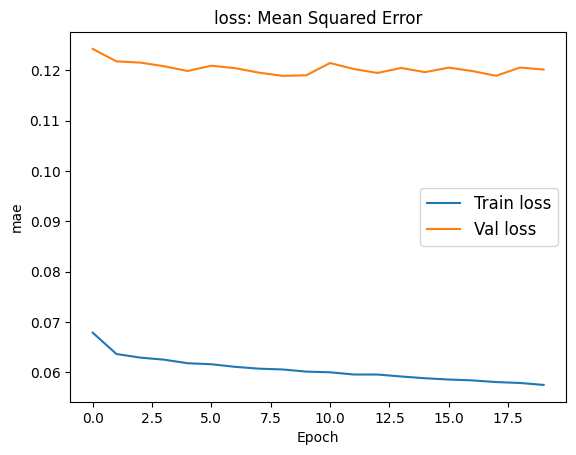

In [11]:
# Hyperparamter tunning using Keras 
# For this section, we attempted to use Keras Tuner to tune the hyperparamters for SO2 predications. It was found that the tuner performed very well
# compared to manual tunning and the final hyperparameters were determined using this method.

#SO2
hyperparameters = {
    'n_neuron' : [32, 64, 128],
    'activation' : ['relu','linear','tanh'],
    'learning_rate' : [0.001, 0.005, 0.01],
    'minibatch_size' : [32,64,128],
    'N_layers' : [2, 4, 6, 8]
}

def create_model(hp):
    model = Sequential()
    # Hyperparameters
    n_neuron = hp.Choice('units', [32, 64, 128])
    activation = hp.Choice('activation', ['relu', 'linear', 'tanh'])
    N_layers = hp.Int('N_layers', min_value=2, max_value=8, step=2)
    learning_rate = hp.Choice('learning_rate', [0.001, 0.005, 0.01])
    minibatch_size = hp.Choice('minibatch_size', [32, 64])
    num_epochs = hp.Int('num_epochs', min_value=10, max_value=100, step=10)
    # Input layer
    model.add(Dense(n_neuron, activation=activation, name="hidden_layer_1", input_shape=(X_train_so2.shape[1],)))
    # Hidden layers
    for n in range(1, N_layers):
        model.add(Dense(n_neuron, activation=activation, name=f"hidden_layer_{n + 1}"))
    # Output layer
    model.add(Dense(1, activation='linear', name="output_layer"))
    # Compile the model
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    return model
    
import keras_tuner as kt
tuner = kt.Hyperband(create_model,
                    objective='val_loss',
                    max_epochs=10,
                    factor=3,
                    project_name='NN_tun_SO2')
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
tuner.search(X_train_so2, y_train_so2, epochs=50, validation_split=0.2, callbacks=[early_stop])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of neurons is {best_hps.get('units')} and the optimal learning rate 
is {best_hps.get('learning_rate')}. Best activation is {best_hps.get('activation')} and the best amount of layers is {best_hps.get('N_layers')} along with the best minibatch being 
{best_hps.get('minibatch_size')} With that, the best number of epochs is {best_hps.get('num_epochs')}.
""")

# # set hyperparameters
n_neuron       = 128
activation     = 'relu' #linear', 'tanh', def my_leaky_relu(x): return tf.nn.leaky_relu(x, alpha=0.01)
num_epochs     = 20
learning_rate  = 0.001
minibatch_size = 64
N_layers       = 4

#Build a neural network from scratch
model = Sequential()
model.add(Dense(n_neuron,  activation=activation, name="hidden_layer_1" ,input_shape=(X_train_so2.shape[1],)))
for n in range(N_layers-1):
    model.add(Dense(n_neuron,  activation=activation, name="hidden_layer_"+str(n+2))) 
model.add(Dense(1,  activation='linear', name="output_layer")) # the output layer
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
model.summary()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = model.fit(X_train_so2, y_train_so2, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])

plt.plot()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss: Mean Squared Error', fontsize=12)
plt.ylabel('mae')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=12)
#plt.savefig("NNSO21.png")

y_test_pre_so2_tun = model.predict(X_test_so2)

# evaluate the predictions
mse_so2 = mean_squared_error(y_test_so2, y_test_pre_so2_tun)
print("Mean Squared Error:", mse_so2)

mae_so2 = mean_absolute_error(y_test_so2, y_test_pre_so2_tun)
print(f"Mean Absolute Error: {mae_so2}")

rmse_so2 = mean_squared_error(y_test_so2, y_test_pre_so2_tun, squared=False)
print(f"Root Mean Squared Error: {rmse_so2}")


Trial 30 Complete [00h 00m 08s]
val_loss: 0.00015548848023172468

Best val_loss So Far: 0.00010665514855645597
Total elapsed time: 00h 01m 26s

The optimal number of neurons is 128 and the optimal learning rate 
is 0.005. Best activation is relu and the best amount of layers is 8 along with the best minibatch being 
64 With that, the best number of epochs is 40.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 64)                384       
                                                                 
 hidden_layer_2 (Dense)      (None, 64)                4160      
                                                                 
 hidden_layer_3 (Dense)      (None, 64)                4160      
                                                                 
 hidden_layer_4 (Dense)      (None, 64)                4160      
                  

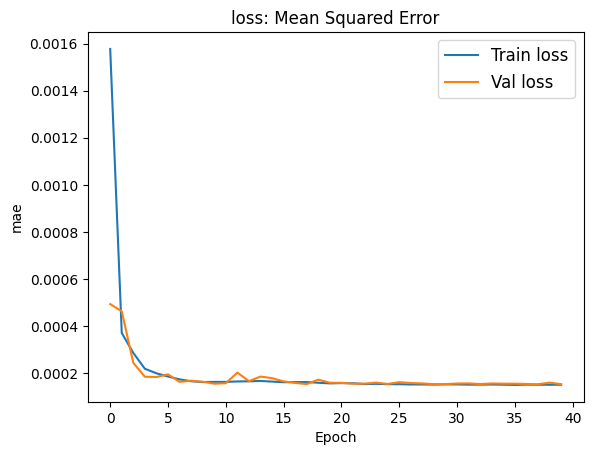

In [12]:
# Hyperparamter tunning using Keras 
# For this section, we attempted to use Keras Tuner to tune the hyperparamters for O3 predications. Keras seemed to overfit for this model
# and so the hyperparameter results produced by Keras was used as a starting point for manual tuning.

#O3
hyperparameters = {
    'n_neuron' : [32, 64, 128],
    'activation' : ['relu','linear','tanh'],
    'learning_rate' : [0.001, 0.005, 0.01],
    'minibatch_size' : [32,64,128],
    'N_layers' : [2, 4, 6, 8]
}

def create_model(hp):
    model = Sequential()
    # Hyperparameters
    n_neuron = hp.Choice('units', [32, 64, 128])
    activation = hp.Choice('activation', ['relu', 'linear', 'tanh'])
    N_layers = hp.Int('N_layers', min_value=2, max_value=8, step=2)
    learning_rate = hp.Choice('learning_rate', [0.001, 0.005, 0.01])
    minibatch_size = hp.Choice('minibatch_size', [32, 64])
    num_epochs = hp.Int('num_epochs', min_value=10, max_value=100, step=10)
    # Input layer
    model.add(Dense(n_neuron, activation=activation, name="hidden_layer_1", input_shape=(X_train_o3.shape[1],)))
    # Hidden layers
    for n in range(1, N_layers):
        model.add(Dense(n_neuron, activation=activation, name=f"hidden_layer_{n + 1}"))
    # Output layer
    model.add(Dense(1, activation='linear', name="output_layer"))
    # Compile the model
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    return model
    
import keras_tuner as kt
tuner = kt.Hyperband(create_model,
                    objective='val_loss',
                    max_epochs=10,
                    factor=3,
                    project_name='NN_tun_O3')
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
tuner.search(X_train_o3, y_train_o3, epochs=50, validation_split=0.2, callbacks=[early_stop])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of neurons is {best_hps.get('units')} and the optimal learning rate 
is {best_hps.get('learning_rate')}. Best activation is {best_hps.get('activation')} and the best amount of layers is {best_hps.get('N_layers')} along with the best minibatch being 
{best_hps.get('minibatch_size')} With that, the best number of epochs is {best_hps.get('num_epochs')}.
""")

# set hyperparameters
n_neuron       = 64
activation     = 'linear' #linear', 'tanh', def my_leaky_relu(x): return tf.nn.leaky_relu(x, alpha=0.01)
num_epochs     = 40
learning_rate  = 0.001
minibatch_size = 32
N_layers       = 4

#Build a neural network from scratch
model = Sequential()
model.add(Dense(n_neuron,  activation=activation, name="hidden_layer_1" ,input_shape=(X_train_so2.shape[1],)))
for n in range(N_layers-1):
    model.add(Dense(n_neuron,  activation=activation, name="hidden_layer_"+str(n+2))) 
model.add(Dense(1,  activation='linear', name="output_layer")) # the output layer
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
model.summary()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = model.fit(X_train_o3, y_train_o3, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])

plt.plot()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss: Mean Squared Error', fontsize=12)
plt.ylabel('mae')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=12)
#plt.savefig("NNO31.png")

y_test_pre_o3_tun = model.predict(X_test_o3)

# evaluate the predictions
mse_o3 = mean_squared_error(y_test_o3, y_test_pre_o3_tun)
print("Mean Squared Error:", mse_so2)

mae_o3 = mean_absolute_error(y_test_o3, y_test_pre_o3_tun)
print(f"Mean Absolute Error: {mae_o3}")

rmse_o3 = mean_squared_error(y_test_o3, y_test_pre_o3_tun, squared=False)
print(f"Root Mean Squared Error: {rmse_o3}")

## CO Model Building

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 32)                192       
                                                                 
 hidden_layer_2 (Dense)      (None, 32)                1056      
                                                                 
 hidden_layer_3 (Dense)      (None, 32)                1056      
                                                                 
 hidden_layer_4 (Dense)      (None, 32)                1056      
                                                                 
 output_layer (Dense)        (None, 1)                 33        
                                                                 
Total params: 3393 (13.25 KB)
Trainable params: 3393 (13.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
356/356 

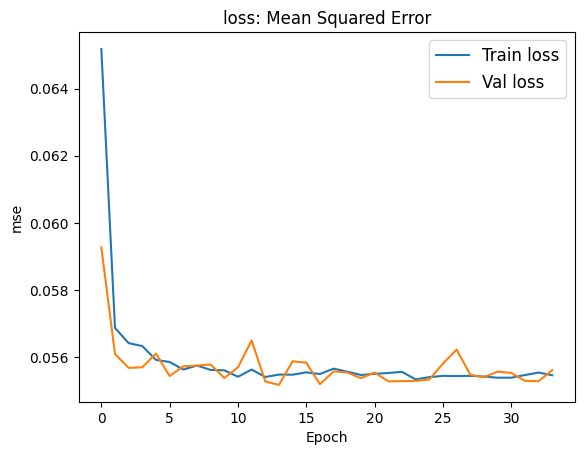

In [13]:
#CO
# Best model based on hyperparameter tuning
# set hyperparameters
n_neuron       = 32
activation     = 'linear' 
num_epochs     = 100
learning_rate  = 0.001
minibatch_size = 64
N_layers       = 4

# Build a neural network from scratch
model1 = Sequential()
model1.add(Dense(n_neuron,  activation=activation, name="hidden_layer_1" ,input_shape=(X_train_co.shape[1],)))
for n in range(N_layers-1):
    model1.add(Dense(n_neuron,  activation=activation, name="hidden_layer_"+str(n+2))) 
model1.add(Dense(1,  activation='linear', name="output_layer")) # the output layer
model1.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
model1.summary()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = model1.fit(X_train_co, y_train_co, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])

plt.plot()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss: Mean Squared Error', fontsize=12)
plt.ylabel('mse')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=12)
#plt.savefig("NNCO.png")



382/382 [==============================] - 0s 355us/step
<class 'numpy.ndarray'>
Mean Squared Error: 0.056895029552298776
Mean Absolute Error: 0.17399294913479757
Root Mean Squared Error: 0.23852679000963137


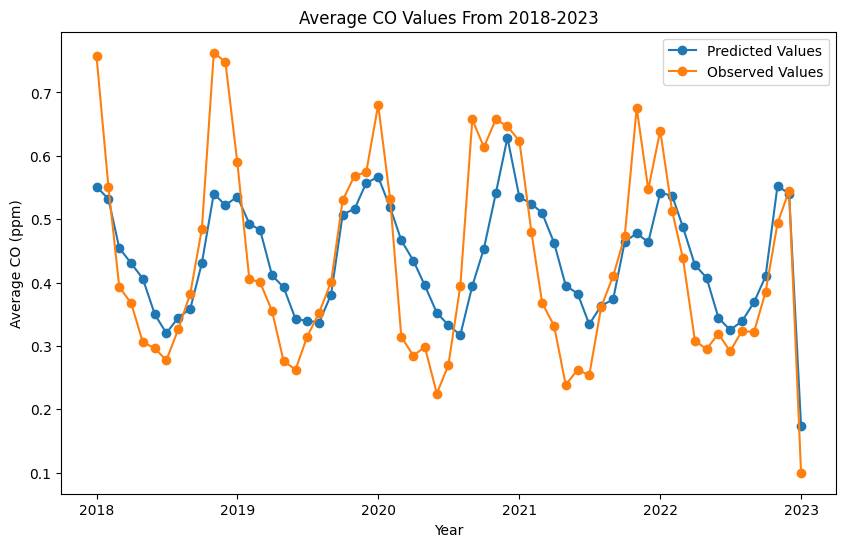

0.5755904851734476


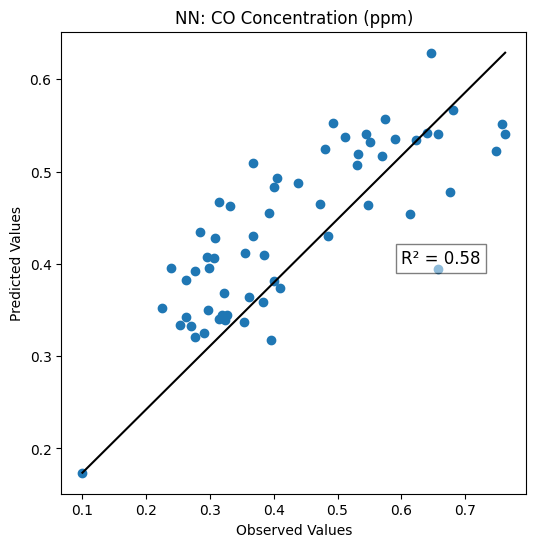

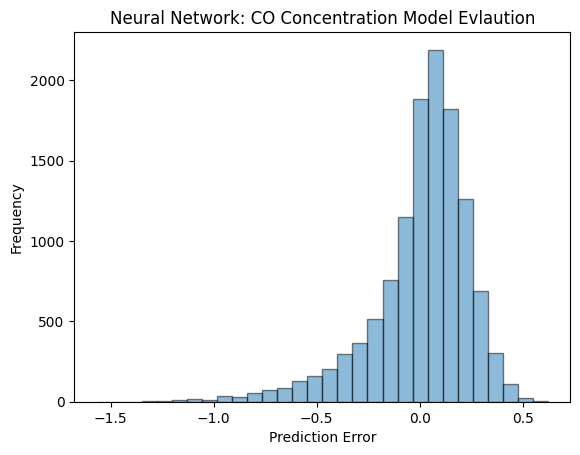

In [14]:
#CO: Apply model and Plot Output
y_test_pre_co2 = model1.predict(X_test_co)

print(type(y_test_pre_co2))

# evaluate the predictions
mse_co = mean_squared_error(y_test_co, y_test_pre_co2)
print("Mean Squared Error:", mse_co)

mae_co = mean_absolute_error(y_test_co, y_test_pre_co2)
print(f"Mean Absolute Error: {mae_co}")

rmse_co = mean_squared_error(y_test_co, y_test_pre_co2, squared=False)
print(f"Root Mean Squared Error: {rmse_co}")


# Organize data into monthly averages and plot
y_test_pre_co2 = y_test_pre_co2[:, 0]
y_test_pre_co2 = pd.Series(y_test_pre_co2)
y_test_pre_co2 = y_test_pre_co2.reset_index(drop=True)
time_test_co = time_test_co.reset_index(drop=True)
co_df  = pd.concat([y_test_pre_co2, time_test_co], axis=1)
co_df.columns = ['CO', 'Date']
co_df['Date'] = pd.to_datetime(co_df['Date'])

# Extract year and month into new columns
co_df['Year'] = co_df['Date'].dt.year
co_df['Month'] = co_df['Date'].dt.month

# Group by year and month, then calculate the mean of the 'CO' column
average_values = co_df.groupby(['Year', 'Month'])['CO'].mean()
average_values_df1 = average_values.reset_index()

#Repeat all above for observed data
y_test_co = pd.Series(y_test_co)
y_test_co = y_test_co.reset_index(drop=True)
co_test_df = pd.concat([y_test_co, time_test_co], axis=1)
co_test_df.columns = ['CO', 'Date']
co_test_df['Date'] = pd.to_datetime(co_test_df['Date'])

# Extract year and month into new columns
co_test_df['Year'] = co_test_df['Date'].dt.year
co_test_df['Month'] = co_test_df['Date'].dt.month

# Group by year and month, then calculate the mean of the 'CO' column
average_values1 = co_test_df.groupby(['Year', 'Month'])['CO'].mean()
average_values_df2 = average_values1.reset_index()

#Change the series values to dataframes.
average_values_df1['Date'] = pd.to_datetime(average_values_df1['Year'].astype(str) + '-' + average_values_df1['Month'].astype(str))
average_values_df2['Date'] = pd.to_datetime(average_values_df2['Year'].astype(str) + '-' + average_values_df2['Month'].astype(str))

# Plotting
plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.plot(average_values_df1['Date'], average_values_df1['CO'], marker='o', label="Predicted Values")  
plt.plot(average_values_df2['Date'], average_values_df2['CO'], marker='o', label="Observed Values") 

# Adding titles and labels
plt.title('Average CO Values From 2018-2023')
plt.xlabel('Year')
plt.ylabel('Average CO (ppm)')
plt.legend()
plt.show()

#Plot R2 
#The following website was utilize: https://www.geeksforgeeks.org/ml-r-squared-in-regression-analysis/
r2 = r2_score(average_values_df2['CO'], average_values_df1['CO'])
print(r2)
plt.figure(figsize=(6, 6))
plt.scatter(average_values_df2['CO'], average_values_df1['CO'])
plt.plot([average_values_df2['CO'].min(), average_values_df2['CO'].max()], [average_values_df1['CO'].min(), average_values_df1['CO'].max()], 'k-')  
plt.title(f'NN: CO Concentration (ppm)')
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.text(0.6, 0.4 , f'R² = {r2:.2f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.show()

   
#Error Prediction Histogram
prediction_error(y_test_pre_co2, y_test_co,'Neural Network', 'CO')


## NO2 Model Building

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 32)                192       
                                                                 
 hidden_layer_2 (Dense)      (None, 32)                1056      
                                                                 
 output_layer (Dense)        (None, 1)                 33        
                                                                 
Total params: 1281 (5.00 KB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/70
712/712 [==============================] - 1s 494us/step - loss: 135.0936 - val_loss: 84.1434
Epoch 2/70
712/712 [==============================] - 0s 436us/step - loss: 81.3814 - val_loss: 78.7386
Epoch 3/70
712/712 [==============================] - 1s 922us/step - loss: 7

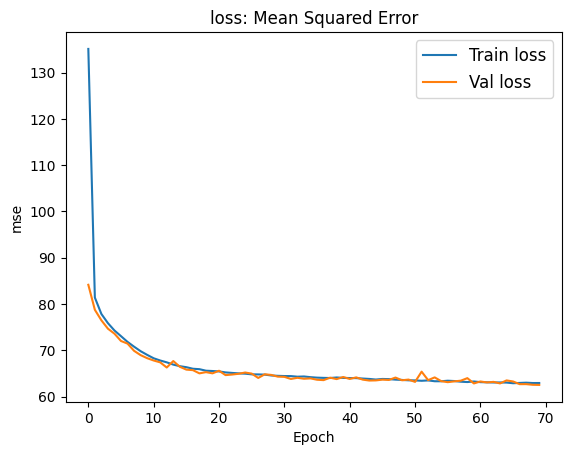

In [15]:
#NO2
# Best model based on hyperparameter tuning
# set hyperparameters
n_neuron       = 32
activation     = 'relu' #linear', 'tanh', def my_leaky_relu(x): return tf.nn.leaky_relu(x, alpha=0.01)
num_epochs     = 70
learning_rate  = 0.001
minibatch_size = 32
N_layers       = 2

# Build a neural network from scratch
model2 = Sequential()
model2.add(Dense(n_neuron,  activation=activation, name="hidden_layer_1" ,input_shape=(X_train_no2.shape[1],)))
for n in range(N_layers-1):
    model2.add(Dense(n_neuron,  activation=activation, name="hidden_layer_"+str(n+2))) 
model2.add(Dense(1,  activation='linear', name="output_layer")) # the output layer
model2.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
model2.summary()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = model2.fit(X_train_no2, y_train_no2, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])

plt.plot()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss: Mean Squared Error', fontsize=12)
plt.ylabel('mse')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=12)
#plt.savefig("NNNO2.png")


382/382 [==============================] - 0s 311us/step
Mean Squared Error: 64.01827356005184
Mean Absolute Error: 5.82912463575025
Root Mean Squared Error: 8.001142015990707


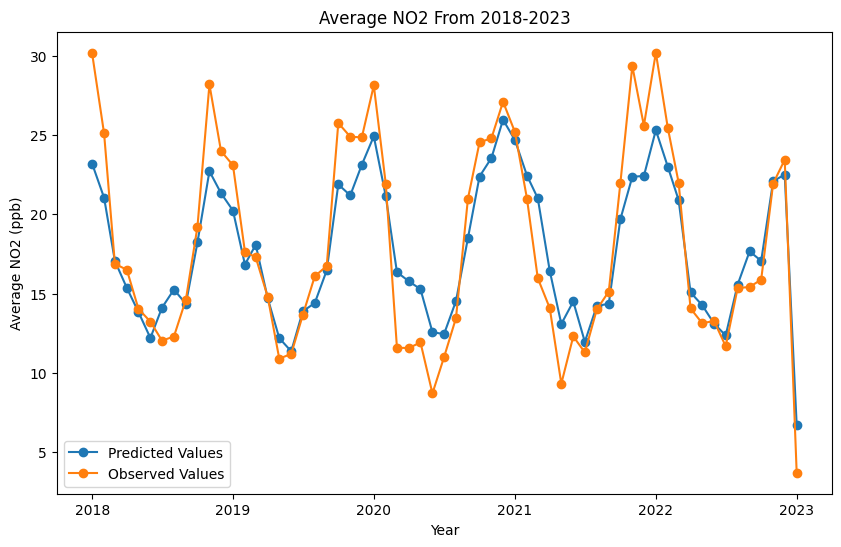

0.8220175385321492


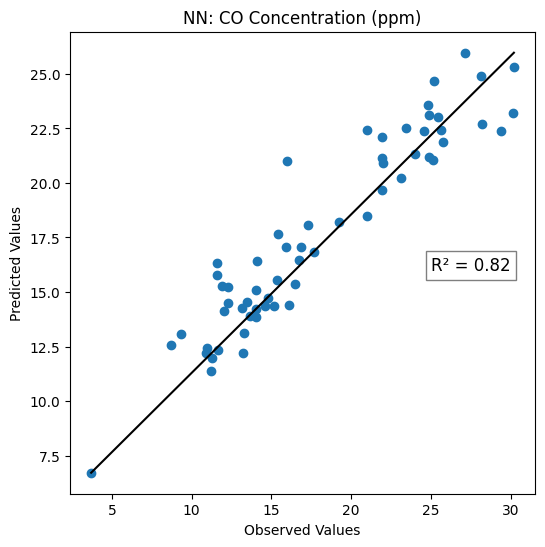

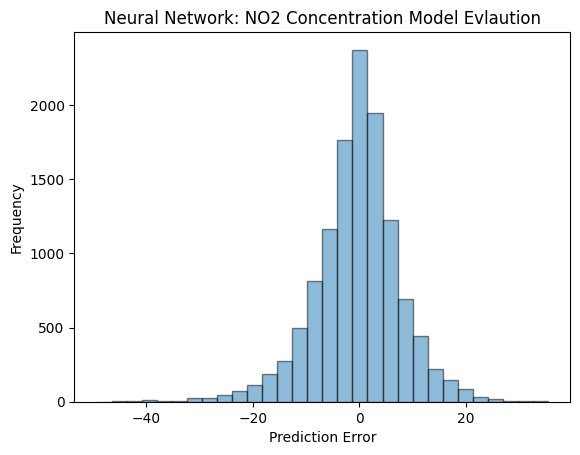

In [16]:
#NO2: Apply model and Plot Output
y_test_pre_no2 = model2.predict(X_test_no2)

# evaluate the predictions
mse_no2 = mean_squared_error(y_test_no2, y_test_pre_no2)
print("Mean Squared Error:", mse_no2)

mae_no2 = mean_absolute_error(y_test_no2, y_test_pre_no2)
print(f"Mean Absolute Error: {mae_no2}")

rmse_no2 = mean_squared_error(y_test_no2, y_test_pre_no2, squared=False)
print(f"Root Mean Squared Error: {rmse_no2}")

# Organize data into monthly averages and plot
y_test_pre_no2 = y_test_pre_no2[:, 0]
y_test_pre_no2 = pd.Series(y_test_pre_no2)
y_test_pre_no2 = y_test_pre_no2.reset_index(drop=True)
time_test_no2 = time_test_no2.reset_index(drop=True)
no2_df  = pd.concat([y_test_pre_no2, time_test_no2], axis=1)
no2_df.columns = ['NO2', 'Date']
no2_df['Date'] = pd.to_datetime(no2_df['Date'])

# Extract year and month into new columns
no2_df['Year'] = no2_df['Date'].dt.year
no2_df['Month'] = no2_df['Date'].dt.month

# Group by year and month, then calculate the mean of the 'CO' column
no2_average_values = no2_df.groupby(['Year', 'Month'])['NO2'].mean()
no2_average_values_df1 = no2_average_values.reset_index()

#Repeat all above for observed data
y_test_no2 = pd.Series(y_test_no2)
y_test_no2 = y_test_no2.reset_index(drop=True)
time_test_no2 = time_test_no2.reset_index(drop=True)
no2_test_df = pd.concat([y_test_no2, time_test_no2], axis=1)
no2_test_df.columns = ['NO2', 'Date']
no2_test_df['Date'] = pd.to_datetime(no2_test_df['Date'])

# Extract year and month into new columns
no2_test_df['Year'] = no2_test_df['Date'].dt.year
no2_test_df['Month'] = no2_test_df['Date'].dt.month

# Group by year and month, then calculate the mean of the 'CO' column
no2_average_values1 = no2_test_df.groupby(['Year', 'Month'])['NO2'].mean()
no2_average_values_df2 = no2_average_values1.reset_index()

#Change the series values to dataframes.
no2_average_values_df1['Date'] = pd.to_datetime(no2_average_values_df1['Year'].astype(str) + '-' + no2_average_values_df1['Month'].astype(str))
no2_average_values_df2['Date'] = pd.to_datetime(no2_average_values_df2['Year'].astype(str) + '-' + no2_average_values_df2['Month'].astype(str))

# Plotting
plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.plot(no2_average_values_df1['Date'], no2_average_values_df1['NO2'], marker='o', label="Predicted Values")  # Create a line plot
plt.plot(no2_average_values_df2['Date'], no2_average_values_df2['NO2'], marker='o', label="Observed Values") 

# Adding titles and labels
plt.title('Average NO2 From 2018-2023')
plt.xlabel('Year')
plt.ylabel('Average NO2 (ppb)')
plt.legend()
plt.show()

#Plot R2 
#The following website was utilize: https://www.geeksforgeeks.org/ml-r-squared-in-regression-analysis/
r2 = r2_score(no2_average_values_df2['NO2'], no2_average_values_df1['NO2'])
print(r2)
plt.figure(figsize=(6, 6))
plt.scatter(no2_average_values_df2['NO2'], no2_average_values_df1['NO2'])
plt.plot([no2_average_values_df2['NO2'].min(), no2_average_values_df2['NO2'].max()], [no2_average_values_df1['NO2'].min(), no2_average_values_df1['NO2'].max()], 'k-')  
plt.title(f'NN: CO Concentration (ppm)')
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.text(25, 16 , f'R² = {r2:.2f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.show()

   
#Error Prediction Histogram
prediction_error(y_test_pre_no2, y_test_no2,'Neural Network', 'NO2')

## SO2 Model Building

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 128)               768       
                                                                 
 hidden_layer_2 (Dense)      (None, 128)               16512     
                                                                 
 hidden_layer_3 (Dense)      (None, 128)               16512     
                                                                 
 hidden_layer_4 (Dense)      (None, 128)               16512     
                                                                 
 output_layer (Dense)        (None, 1)                 129       
                                                                 
Total params: 50433 (197.00 KB)
Trainable params: 50433 (197.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
356/3

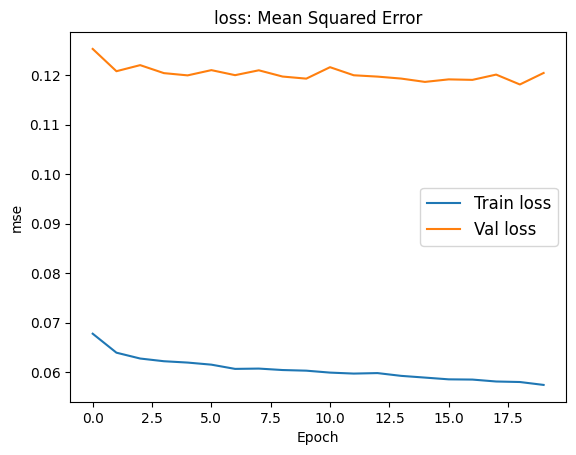

In [18]:
#SO2
# Best model based on hyperparameter tuning
# set hyperparameters
n_neuron       = 128
activation     = 'relu' #linear', 'tanh', def my_leaky_relu(x): return tf.nn.leaky_relu(x, alpha=0.01)
num_epochs     = 20
learning_rate  = 0.001
minibatch_size = 64
N_layers       = 4

# Build a neural network from scratch
model3 = Sequential()
model3.add(Dense(n_neuron,  activation=activation, name="hidden_layer_1" ,input_shape=(X_train_so2.shape[1],)))
for n in range(N_layers-1):
    model3.add(Dense(n_neuron,  activation=activation, name="hidden_layer_"+str(n+2))) 
model3.add(Dense(1,  activation='linear', name="output_layer")) # the output layer
model3.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
model3.summary()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = model3.fit(X_train_so2, y_train_so2, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])

plt.plot()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss: Mean Squared Error', fontsize=12)
plt.ylabel('mse')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=12)
#plt.savefig("NNSO2.png")

382/382 [==============================] - 0s 353us/step
Mean Squared Error: 0.06330670296804015
Mean Absolute Error: 0.17415140996176703
Root Mean Squared Error: 0.251608233108617


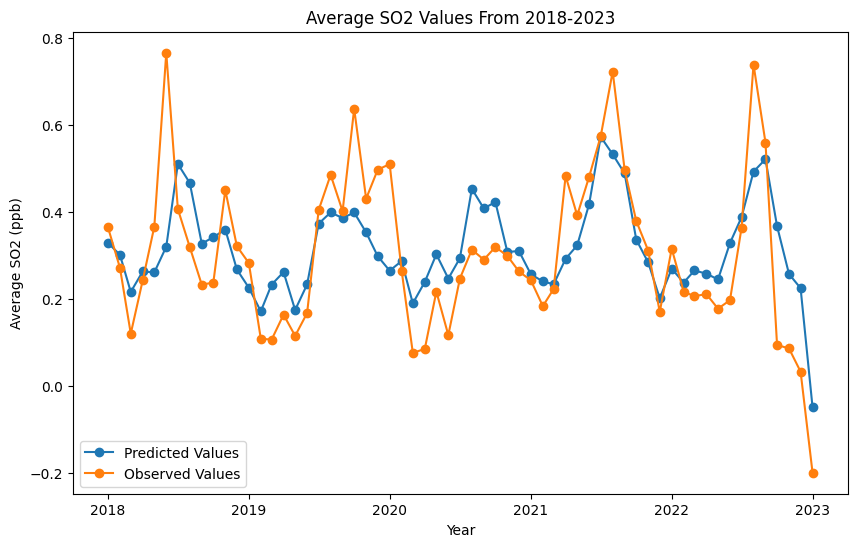

0.5235211097882227


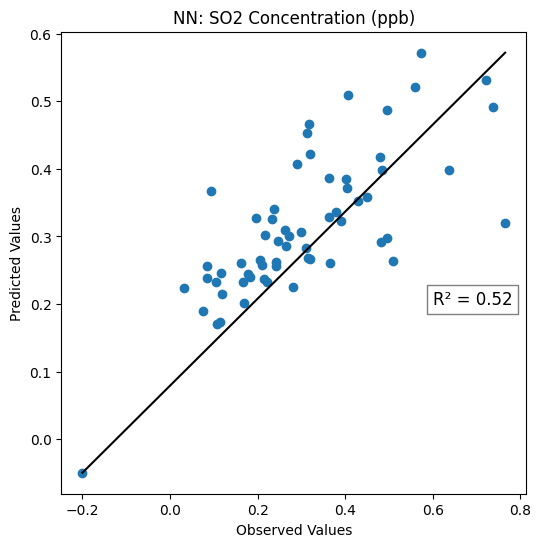

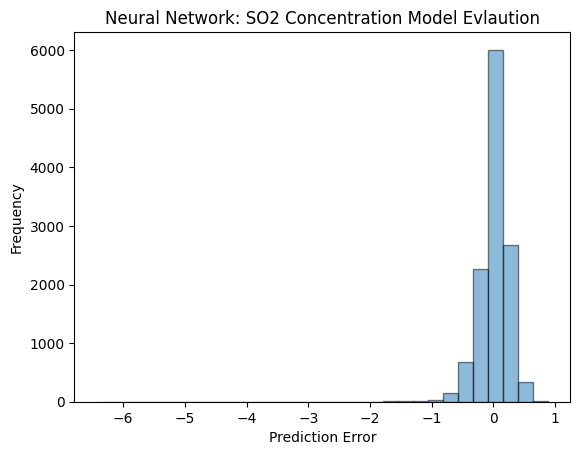

In [22]:
#SO2: Apply model and Plot Output
y_test_pre_so2 = model3.predict(X_test_so2)

# evaluate the predictions
mse_so2 = mean_squared_error(y_test_so2, y_test_pre_so2)
print("Mean Squared Error:", mse_so2)

mae_so2 = mean_absolute_error(y_test_so2, y_test_pre_so2)
print(f"Mean Absolute Error: {mae_so2}")

rmse_so2 = mean_squared_error(y_test_so2, y_test_pre_so2, squared=False)
print(f"Root Mean Squared Error: {rmse_so2}")


## Organize data into monthly averages and plot
#y_test_pre_so2 = y_test_pre_so2[:, 0]
y_test_pre_so2 = y_test_pre_so2.flatten()
y_test_pre_so2 = pd.Series(y_test_pre_so2)
y_test_pre_so2 = y_test_pre_so2.reset_index(drop=True)
time_test_so2 = time_test_so2.reset_index(drop=True)
so2_df  = pd.concat([y_test_pre_so2, time_test_so2], axis=1)
so2_df.columns = ['SO2', 'Date']
so2_df['Date'] = pd.to_datetime(so2_df['Date'])

# Extract year and month into new columns
so2_df['Year'] = so2_df['Date'].dt.year
so2_df['Month'] = so2_df['Date'].dt.month

# Group by year and month, then calculate the mean of the 'CO' column
so2_average_values = so2_df.groupby(['Year', 'Month'])['SO2'].mean()
so2_average_values_df1 = so2_average_values.reset_index()

#Repeat all above for observed data
y_test_so2 = pd.Series(y_test_so2)
y_test_so2 = y_test_so2.reset_index(drop=True)
time_test_so2 = time_test_so2.reset_index(drop=True)
so2_test_df = pd.concat([y_test_so2, time_test_so2], axis=1)
so2_test_df.columns = ['SO2', 'Date']
so2_test_df['Date'] = pd.to_datetime(so2_test_df['Date'])

# Extract year and month into new columns
so2_test_df['Year'] = so2_test_df['Date'].dt.year
so2_test_df['Month'] = so2_test_df['Date'].dt.month

# Group by year and month, then calculate the mean of the 'CO' column
so2_average_values1 = so2_test_df.groupby(['Year', 'Month'])['SO2'].mean()
so2_average_values_df2 = so2_average_values1.reset_index()

#Change the series values to dataframes.
so2_average_values_df1['Date'] = pd.to_datetime(so2_average_values_df1['Year'].astype(str) + '-' + so2_average_values_df1['Month'].astype(str))
so2_average_values_df2['Date'] = pd.to_datetime(so2_average_values_df2['Year'].astype(str) + '-' + so2_average_values_df2['Month'].astype(str))

# Plotting
plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.plot(so2_average_values_df1['Date'], so2_average_values_df1['SO2'], marker='o', label="Predicted Values")  # Create a line plot
plt.plot(so2_average_values_df2['Date'], so2_average_values_df2['SO2'], marker='o', label="Observed Values") 

# Adding titles and labels
plt.title('Average SO2 Values From 2018-2023')
plt.xlabel('Year')
plt.ylabel('Average SO2 (ppb)')
plt.legend()
plt.show()

#Plot R2 
#The following website was utilize: https://www.geeksforgeeks.org/ml-r-squared-in-regression-analysis/
r2 = r2_score(so2_average_values_df2['SO2'], so2_average_values_df1['SO2'])
print(r2)
plt.figure(figsize=(6, 6))
plt.scatter(so2_average_values_df2['SO2'], so2_average_values_df1['SO2'])
plt.plot([so2_average_values_df2['SO2'].min(), so2_average_values_df2['SO2'].max()], [so2_average_values_df1['SO2'].min(), so2_average_values_df1['SO2'].max()], 'k-')  
plt.title(f'NN: SO2 Concentration (ppb)')
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.text(0.6, 0.2 , f'R² = {r2:.2f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.show()

#Prediction Error Histogram
prediction_error(y_test_pre_so2, y_test_so2, 'Neural Network','SO2')


## O3 Model Building

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 64)                384       
                                                                 
 hidden_layer_2 (Dense)      (None, 64)                4160      
                                                                 
 hidden_layer_3 (Dense)      (None, 64)                4160      
                                                                 
 hidden_layer_4 (Dense)      (None, 64)                4160      
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 12929 (50.50 KB)
Trainable params: 12929 (50.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
712/712

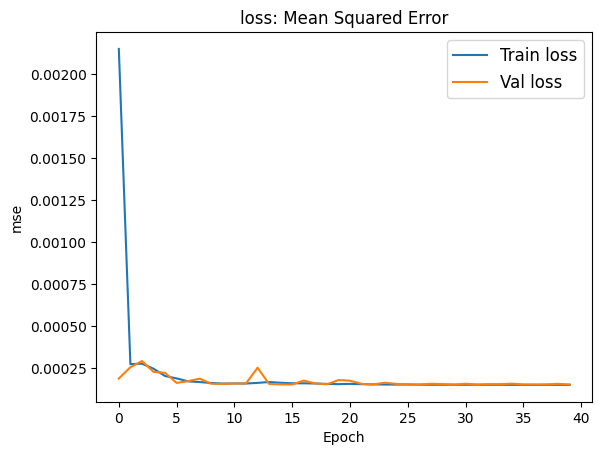

In [23]:
#O3
# Best model based on hyperparameter tuning
# set hyperparameters
n_neuron       = 64
activation     = 'linear' #linear', 'tanh', def my_leaky_relu(x): return tf.nn.leaky_relu(x, alpha=0.01)
num_epochs     = 40
learning_rate  = 0.001
minibatch_size = 32
N_layers       = 4

# Build a neural network from scratch
model4 = Sequential()
model4.add(Dense(n_neuron,  activation=activation, name="hidden_layer_1" ,input_shape=(X_train_o3.shape[1],)))
for n in range(N_layers-1):
    model4.add(Dense(n_neuron,  activation=activation, name="hidden_layer_"+str(n+2))) 
model4.add(Dense(1,  activation='linear', name="output_layer")) # the output layer
model4.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
model4.summary()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = model4.fit(X_train_o3, y_train_o3, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])

plt.plot()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss: Mean Squared Error', fontsize=12)
plt.ylabel('mse')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=12)
#plt.savefig("NNO3.png")

382/382 [==============================] - 0s 311us/step
Mean Squared Error: 0.00015020879096575856
Mean Absolute Error: 0.009803191294495313
Root Mean Squared Error: 0.012255969605288623


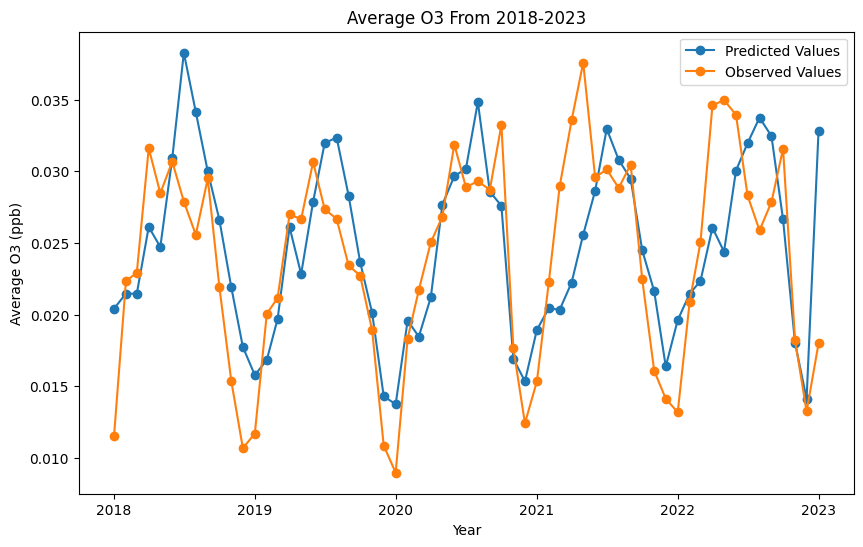

0.4551016399372879


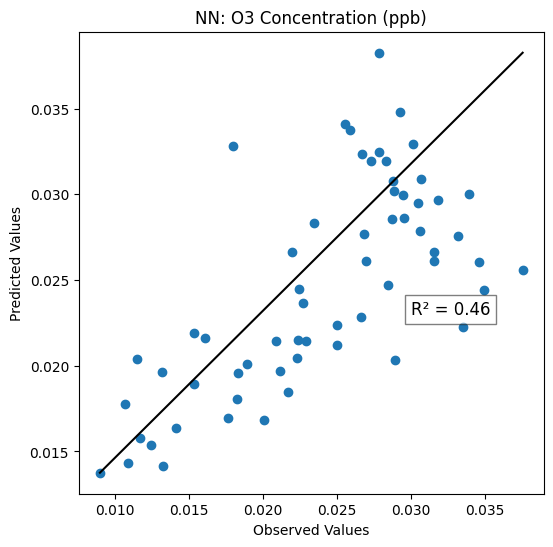

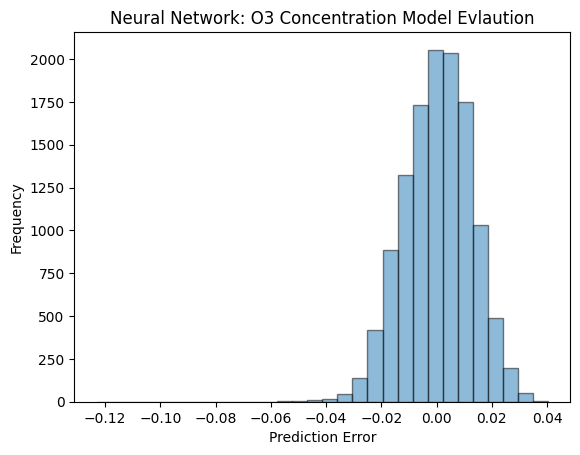

In [26]:
#O3: Apply model and Plot Output
y_test_pre_o3 = model4.predict(X_test_o3)

# evaluate the predictions
mse_o3 = mean_squared_error(y_test_o3, y_test_pre_o3)
print("Mean Squared Error:", mse_o3)

mae_o3 = mean_absolute_error(y_test_o3, y_test_pre_o3)
print(f"Mean Absolute Error: {mae_o3}")

rmse_o3 = mean_squared_error(y_test_o3, y_test_pre_o3, squared=False)
print(f"Root Mean Squared Error: {rmse_o3}")

# Organize data into monthly averages and plot
y_test_pre_o3  = y_test_pre_o3 [:, 0]
y_test_pre_o3  = pd.Series(y_test_pre_o3 )
y_test_pre_o3  = y_test_pre_o3.reset_index(drop=True)
time_test_o3 = time_test_o3.reset_index(drop=True)
o3_df  = pd.concat([y_test_pre_o3, time_test_o3], axis=1)
o3_df.columns = ['O3', 'Date']
o3_df['Date'] = pd.to_datetime(o3_df['Date'])

# Extract year and month into new columns
o3_df['Year'] = o3_df['Date'].dt.year
o3_df['Month'] = o3_df['Date'].dt.month

# Group by year and month, then calculate the mean of the 'CO' column
o3_average_values = o3_df.groupby(['Year', 'Month'])['O3'].mean()
o3_average_values_df1 = o3_average_values.reset_index()

#Repeat all above for observed data
y_test_o3 = pd.Series(y_test_o3)
y_test_o3 = y_test_o3.reset_index(drop=True)
time_test_o3 = time_test_o3.reset_index(drop=True)
o3_test_df = pd.concat([y_test_o3, time_test_o3], axis=1)
o3_test_df.columns = ['O3', 'Date']
o3_test_df['Date'] = pd.to_datetime(o3_test_df['Date'])

# Extract year and month into new columns
o3_test_df['Year'] = o3_test_df['Date'].dt.year
o3_test_df['Month'] = o3_test_df['Date'].dt.month

# Group by year and month, then calculate the mean of the 'CO' column
o3_average_values1 = o3_test_df.groupby(['Year', 'Month'])['O3'].mean()
o3_average_values_df2 = o3_average_values1.reset_index()

#Change the series values to dataframes.
o3_average_values_df1['Date'] = pd.to_datetime(o3_average_values_df1['Year'].astype(str) + '-' + o3_average_values_df1['Month'].astype(str))
o3_average_values_df2['Date'] = pd.to_datetime(o3_average_values_df2['Year'].astype(str) + '-' + o3_average_values_df2['Month'].astype(str))

# Plotting
plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.plot(o3_average_values_df1['Date'], o3_average_values_df1['O3'], marker='o', label="Predicted Values")  # Create a line plot
plt.plot(o3_average_values_df2['Date'], o3_average_values_df2['O3'], marker='o', label="Observed Values") 

# Adding titles and labels
plt.title('Average O3 From 2018-2023')
plt.xlabel('Year')
plt.ylabel('Average O3 (ppb)')
plt.legend()
plt.show()

#Plot R2 
#The following website was utilize: https://www.geeksforgeeks.org/ml-r-squared-in-regression-analysis/
r2 = r2_score(o3_average_values_df2['O3'], o3_average_values_df1['O3'])
print(r2)
plt.figure(figsize=(6, 6))
plt.scatter(o3_average_values_df2['O3'], o3_average_values_df1['O3'])
plt.plot([o3_average_values_df2['O3'].min(), o3_average_values_df2['O3'].max()], [o3_average_values_df1['O3'].min(), o3_average_values_df1['O3'].max()], 'k-')  
plt.title(f'NN: O3 Concentration (ppb)')
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.text(0.030, 0.023 , f'R² = {r2:.2f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.show()

#Prediction Error Histogram
prediction_error(y_test_pre_o3, y_test_o3, 'Neural Network','O3')



## Meteorological Normalization

In [27]:
df_orig = pd.read_excel("Data/metdata_2018-2023_ELABHWC.xlsx")
sum_of_predictions_co, sum_of_predictions_no2 = np.zeros([43789]), np.zeros([43789])
sum_of_predictions_so2, sum_of_predictions_o3 = np.zeros([43789]), np.zeros([43789])
number_of_iterations = 25

for i in range(number_of_iterations):
    df_rand = pd.read_excel(f"Data/random_weather_datasets/output_{i+1}.xlsx")
    
    df_rand['date_gmt'] = df_orig['date_gmt']
    df_rand['time_gmt'] = df_orig['time_gmt']
    
    df_rand.loc[:, 'wind speed'].fillna(df_new['wind speed'].mean(), inplace=True)
    df_rand.loc[:, 'wind direction'].fillna(df_new['wind direction'].mean(), inplace=True)
    df_rand.loc[:, 'temp'].fillna(df_new['temp'].mean(), inplace=True)
    df_rand.loc[:, 'rh'].fillna(df_new['rh'].mean(), inplace=True)
    df_rand.loc[:, 'pressure'].fillna(df_new['pressure'].mean(), inplace=True)

    X = df_rand[['wind speed', 'wind direction', 'temp', 'rh', 'pressure','date_gmt']]
    
    X = X[['wind speed', 'wind direction', 'temp', 'rh', 'pressure']]
    #time_co = X_co['date_gmt']
    
    mean, std = X.mean(), X.std()
    
    X = (X - mean)/std
    
    X = X.to_numpy()
    
    Y_co = model1.predict(X).flatten()
    sum_of_predictions_co += Y_co

    Y_no2 = model2.predict(X).flatten()
    sum_of_predictions_no2 += Y_no2
    
    Y_so2 = model3.predict(X).flatten()
    sum_of_predictions_so2 += Y_so2
    
    Y_o3 = model4.predict(X).flatten()
    sum_of_predictions_o3 += Y_o3


average_predictions_co = sum_of_predictions_co / number_of_iterations
average_predictions_no2 = sum_of_predictions_no2 / number_of_iterations
average_predictions_so2 = sum_of_predictions_so2 / number_of_iterations
average_predictions_o3 = sum_of_predictions_o3 / number_of_iterations

timeforplot = df_orig['date_gmt']

1369/1369 [==============================] - 0s 312us/step


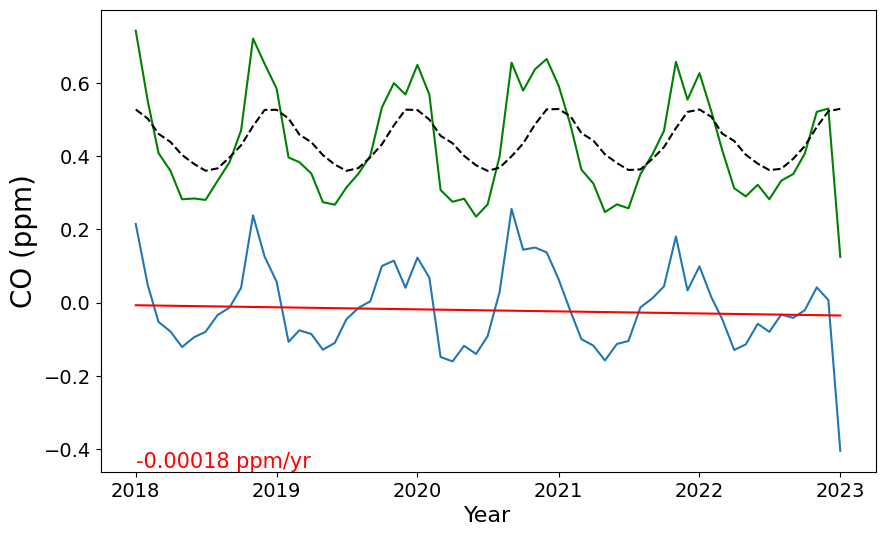

In [33]:
# CO PLOT OF WEATHER NORMALIZATION

weather_norm_co = pd.Series(co_original - average_predictions_co)
y_co = pd.Series(co_original)
weather_prediction_co = pd.Series(average_predictions_co)
timeforplot = timeforplot.reset_index(drop=True)

#Create DataFrame for predicted values
co_df = pd.concat([weather_norm_co, timeforplot], axis=1)
co_df.columns = ['CO', 'Date']
co_df['Date'] = pd.to_datetime(co_df['Date'])

#Group by year and month, then calculate the mean of the 'CO' column
co_df['Year'] = co_df['Date'].dt.year
co_df['Month'] = co_df['Date'].dt.month
average_values_1 = co_df.groupby(['Year', 'Month'])['CO'].mean()

average_values_df1 = average_values.reset_index()

co_actual_df = pd.concat([y_co, timeforplot], axis=1)
co_actual_df.columns = ['CO', 'Date']
co_actual_df['Date'] = pd.to_datetime(co_df['Date'])

#Do the same thing for the observed values
co_df['Year'] = co_df['Date'].dt.year
co_df['Month'] = co_df['Date'].dt.month
average_values = co_df.groupby(['Year', 'Month'])['CO'].mean()
co_actual_df['Year'] = co_actual_df['Date'].dt.year
co_actual_df['Month'] = co_actual_df['Date'].dt.month
average_values_2 = co_actual_df.groupby(['Year', 'Month'])['CO'].mean()

average_values_df1 = average_values_1.reset_index()
average_values_df2 = average_values_2.reset_index()


average_values_df1['Year'] = average_values_df1['Year'].astype(int)
average_values_df1['Month'] = average_values_df1['Month'].astype(int)
average_values_df1['Date'] = pd.to_datetime(average_values_df1['Year'].astype(str) + '-' + average_values_df1['Month'].astype(str))

average_values_df2['Year'] = average_values_df2['Year'].astype(int)
average_values_df2['Month'] = average_values_df2['Month'].astype(int)
average_values_df2['Date'] = pd.to_datetime(average_values_df2['Year'].astype(str) + '-' + average_values_df2['Month'].astype(str))

#Now plotting the meteorological average values
weather_df = pd.concat([weather_prediction_co, timeforplot], axis=1)
weather_df.columns = ['CO', 'Date']
weather_df['Date'] = pd.to_datetime(no2_df['Date'])
weather_df['Year'] = weather_df['Date'].dt.year
weather_df['Month'] = weather_df['Date'].dt.month
average_values_3 = weather_df.groupby(['Year', 'Month'])['CO'].mean()
average_values_df3 = average_values_3.reset_index()
average_values_df3['Year'] = average_values_df3['Year'].astype(int)
average_values_df3['Month'] = average_values_df3['Month'].astype(int)
average_values_df3['Date'] = pd.to_datetime(average_values_df3['Year'].astype(str) + '-' + average_values_df3['Month'].astype(str))

#Plotting
plt.figure(figsize=(10, 6))
plt.plot(average_values_df1['Date'], average_values_df1['CO'], label="Weather Normalized Vals")
plt.plot(average_values_df2['Date'], average_values_df2['CO'], color='g', label="Observed Values")
plt.plot(average_values_df3['Date'], average_values_df3['CO'], linestyle='dashed', color='k', label="met average vals")

#Theil Sen Regression

x_numeric = pd.to_datetime(average_values_df1['Date']).apply(lambda date: date.toordinal())
y = average_values_df1['CO']

#Calculate the slopes between all pairs of points
slopes = [(y[j] - y[i]) / (x_numeric[j] - x_numeric[i]) 
          for i in range(len(average_values_df1)) 
          for j in range(i+1, len(average_values_df1))]

#Calculate median slope
median_slope = np.median(slopes)
annualized_slope = median_slope * 12
formatted_slope = f"{annualized_slope:.5f}"

#Calculate intercepts for each point
intercepts = [y[i] - median_slope * x_numeric[i] for i in range(len(average_values_df1))]

#Calculate median intercept
median_intercept = np.median(intercepts)

#Plotting
x_range = pd.date_range(start=average_values_df1['Date'].min(), end=average_values_df1['Date'].max(), freq='D')
y_range = median_slope * pd.to_datetime(x_range).map(datetime.toordinal) + median_intercept


plt.plot(x_range, y_range, color='red', label='Theil-Sen Regression Line')

#Format slope and intercept for display (e.g., rounding to 2 decimal places)
formatted_slope = f"{median_slope*12:.5f}"

#Place the text on the plot
#Determine the position for the text
x_position = average_values_df1['Date'].min()
y_position = plt.gca().get_ylim()[0]  # Get the minimum y value of the current axis

# Increase font size of ticks, labels, and title
plt.xticks(fontsize=14)  # Increase x-axis tick font size
plt.yticks(fontsize=14)  # Increase y-axis tick font size
plt.xlabel('Year', fontsize=16)  # Increase x-axis label font size
plt.ylabel('CO (ppm)', fontsize=20)  # Increase y-axis label font size
plt.text(x_position, y_position, f'{formatted_slope} ppm/yr', fontsize=15, verticalalignment='bottom', color='red')

plt.show()

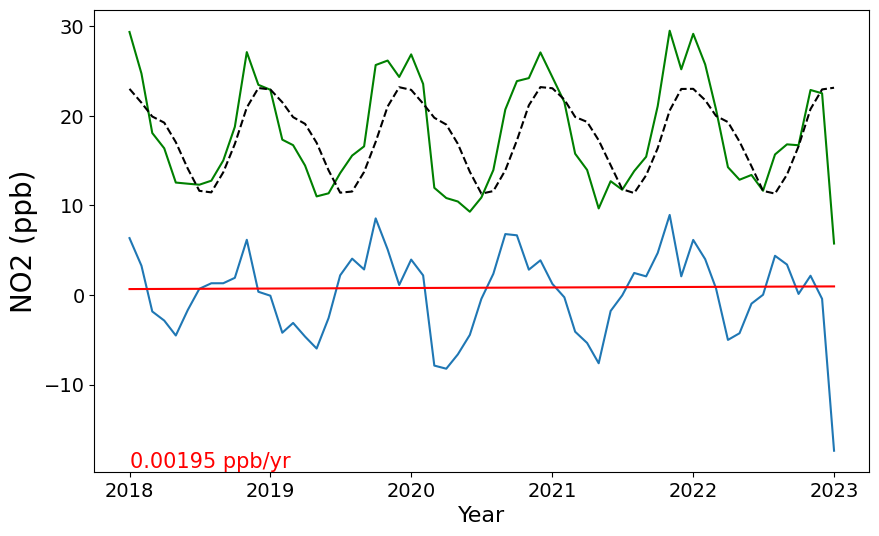

In [30]:
#NO2 PLOT OF WEATHER NORMALIZATION

weather_norm_no2 = pd.Series(no2_original - average_predictions_no2)
y_no2 = pd.Series(no2_original)
weather_prediction_no2 = pd.Series(average_predictions_no2)
timeforplot = timeforplot.reset_index(drop=True)

#Create DataFrame for predicted values
no2_df = pd.concat([weather_norm_no2, timeforplot], axis=1)
no2_df.columns = ['NO2', 'Date']
no2_df['Date'] = pd.to_datetime(no2_df['Date'])

no2_df['Year'] = no2_df['Date'].dt.year
no2_df['Month'] = no2_df['Date'].dt.month
average_values_1 = no2_df.groupby(['Year', 'Month'])['NO2'].mean()

average_values_df1 = average_values.reset_index()

no2_actual_df = pd.concat([y_no2, timeforplot], axis=1)
no2_actual_df.columns = ['NO2', 'Date']
no2_actual_df['Date'] = pd.to_datetime(no2_df['Date'])

#Do the same thing for the observed values
no2_df['Year'] = no2_df['Date'].dt.year
no2_df['Month'] = no2_df['Date'].dt.month
average_values = no2_df.groupby(['Year', 'Month'])['NO2'].mean()
no2_actual_df['Year'] = no2_actual_df['Date'].dt.year
no2_actual_df['Month'] = no2_actual_df['Date'].dt.month
average_values_2 = no2_actual_df.groupby(['Year', 'Month'])['NO2'].mean()

average_values_df1 = average_values_1.reset_index()
average_values_df2 = average_values_2.reset_index()


average_values_df1['Year'] = average_values_df1['Year'].astype(int)
average_values_df1['Month'] = average_values_df1['Month'].astype(int)
average_values_df1['Date'] = pd.to_datetime(average_values_df1['Year'].astype(str) + '-' + average_values_df1['Month'].astype(str))

average_values_df2['Year'] = average_values_df2['Year'].astype(int)
average_values_df2['Month'] = average_values_df2['Month'].astype(int)
average_values_df2['Date'] = pd.to_datetime(average_values_df2['Year'].astype(str) + '-' + average_values_df2['Month'].astype(str))

#Now plotting the meteorological average values
weather_df = pd.concat([weather_prediction_no2, timeforplot], axis=1)
weather_df.columns = ['NO2', 'Date']
weather_df['Date'] = pd.to_datetime(no2_df['Date'])
weather_df['Year'] = weather_df['Date'].dt.year
weather_df['Month'] = weather_df['Date'].dt.month
average_values_3 = weather_df.groupby(['Year', 'Month'])['NO2'].mean()
average_values_df3 = average_values_3.reset_index()
average_values_df3['Year'] = average_values_df3['Year'].astype(int)
average_values_df3['Month'] = average_values_df3['Month'].astype(int)
average_values_df3['Date'] = pd.to_datetime(average_values_df3['Year'].astype(str) + '-' + average_values_df3['Month'].astype(str))

#Plotting
plt.figure(figsize=(10, 6))
plt.plot(average_values_df1['Date'], average_values_df1['NO2'], label="Weather Normalized Vals")
plt.plot(average_values_df2['Date'], average_values_df2['NO2'], color='g', label="Observed Values")
plt.plot(average_values_df3['Date'], average_values_df3['NO2'], linestyle='dashed', color='k', label="met average vals")

#Theil Sen Regression

x_numeric = pd.to_datetime(average_values_df1['Date']).apply(lambda date: date.toordinal())
y = average_values_df1['NO2']

#Calculate the slopes between all pairs of points
slopes = [(y[j] - y[i]) / (x_numeric[j] - x_numeric[i]) 
          for i in range(len(average_values_df1)) 
          for j in range(i+1, len(average_values_df1))]

#Calculate median slope
median_slope = np.median(slopes)
annualized_slope = median_slope * 12
formatted_slope = f"{annualized_slope:.5f}"

#Calculate intercepts for each point
intercepts = [y[i] - median_slope * x_numeric[i] for i in range(len(average_values_df1))]

#Calculate median intercept
median_intercept = np.median(intercepts)

#Plotting
x_range = pd.date_range(start=average_values_df1['Date'].min(), end=average_values_df1['Date'].max(), freq='D')
y_range = median_slope * pd.to_datetime(x_range).map(datetime.toordinal) + median_intercept


plt.plot(x_range, y_range, color='red', label='Theil-Sen Regression Line')

#Format slope and intercept for display (e.g., rounding to 2 decimal places)
formatted_slope = f"{median_slope*12:.5f}"

#Place the text on the plot
#Determine the position for the text
x_position = average_values_df1['Date'].min()
y_position = plt.gca().get_ylim()[0]  # Get the minimum y value of the current axis

# Increase font size of ticks, labels, and title
plt.xticks(fontsize=14)  # Increase x-axis tick font size
plt.yticks(fontsize=14)  # Increase y-axis tick font size
plt.xlabel('Year', fontsize=16)  # Increase x-axis label font size
plt.ylabel('NO2 (ppb)', fontsize=20)  # Increase y-axis label font size

plt.text(x_position, y_position, f'{formatted_slope} ppb/yr', fontsize=15, verticalalignment='bottom', color='red')

plt.show()

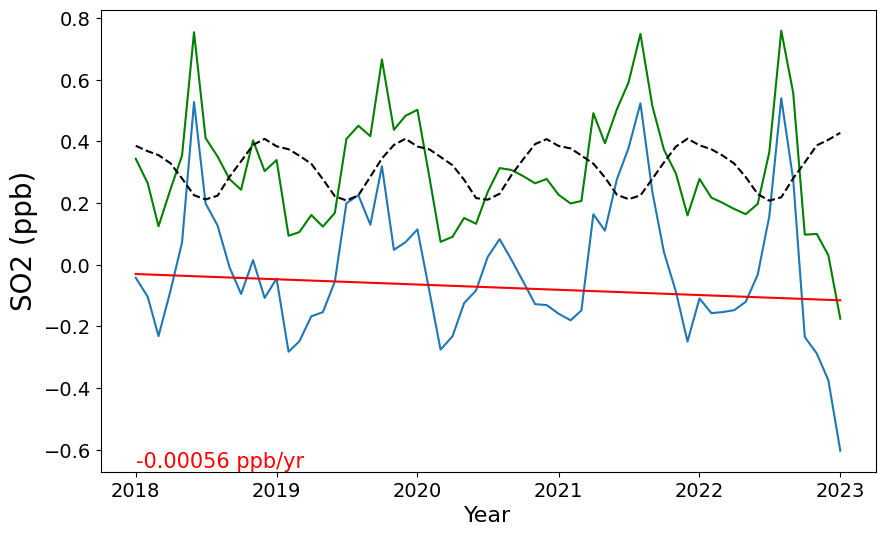

In [31]:
#SO2 PLOT OF WEATHER NORMALIZATION

weather_norm_so2 = pd.Series(so2_original - average_predictions_so2)
y_so2 = pd.Series(so2_original)
weather_prediction_so2 = pd.Series(average_predictions_so2)
timeforplot = timeforplot.reset_index(drop=True)

#Create DataFrame for predicted values
so2_df = pd.concat([weather_norm_so2, timeforplot], axis=1)
so2_df.columns = ['SO2', 'Date']
so2_df['Date'] = pd.to_datetime(so2_df['Date'])

so2_df['Year'] = so2_df['Date'].dt.year
so2_df['Month'] = so2_df['Date'].dt.month
average_values_1 = so2_df.groupby(['Year', 'Month'])['SO2'].mean()

average_values_df1 = average_values.reset_index()

so2_actual_df = pd.concat([y_so2, timeforplot], axis=1)
so2_actual_df.columns = ['SO2', 'Date']
so2_actual_df['Date'] = pd.to_datetime(so2_df['Date'])

#Do the same thing for the observed values
so2_df['Year'] = so2_df['Date'].dt.year
so2_df['Month'] = so2_df['Date'].dt.month
average_values = so2_df.groupby(['Year', 'Month'])['SO2'].mean()
so2_actual_df['Year'] = so2_actual_df['Date'].dt.year
so2_actual_df['Month'] = so2_actual_df['Date'].dt.month
average_values_2 = so2_actual_df.groupby(['Year', 'Month'])['SO2'].mean()

average_values_df1 = average_values_1.reset_index()
average_values_df2 = average_values_2.reset_index()


average_values_df1['Year'] = average_values_df1['Year'].astype(int)
average_values_df1['Month'] = average_values_df1['Month'].astype(int)
average_values_df1['Date'] = pd.to_datetime(average_values_df1['Year'].astype(str) + '-' + average_values_df1['Month'].astype(str))

average_values_df2['Year'] = average_values_df2['Year'].astype(int)
average_values_df2['Month'] = average_values_df2['Month'].astype(int)
average_values_df2['Date'] = pd.to_datetime(average_values_df2['Year'].astype(str) + '-' + average_values_df2['Month'].astype(str))

#Now plotting the meteorological average values
weather_df = pd.concat([weather_prediction_so2, timeforplot], axis=1)
weather_df.columns = ['SO2', 'Date']
weather_df['Date'] = pd.to_datetime(so2_df['Date'])
weather_df['Year'] = weather_df['Date'].dt.year
weather_df['Month'] = weather_df['Date'].dt.month
average_values_3 = weather_df.groupby(['Year', 'Month'])['SO2'].mean()
average_values_df3 = average_values_3.reset_index()
average_values_df3['Year'] = average_values_df3['Year'].astype(int)
average_values_df3['Month'] = average_values_df3['Month'].astype(int)
average_values_df3['Date'] = pd.to_datetime(average_values_df3['Year'].astype(str) + '-' + average_values_df3['Month'].astype(str))

#Plotting
plt.figure(figsize=(10, 6))
plt.plot(average_values_df1['Date'], average_values_df1['SO2'], label="Weather Normalized Vals")
plt.plot(average_values_df2['Date'], average_values_df2['SO2'], color='g', label="Observed Values")
plt.plot(average_values_df3['Date'], average_values_df3['SO2'], linestyle='dashed', color='k', label="met average vals")

#Theil Sen Regression

x_numeric = pd.to_datetime(average_values_df1['Date']).apply(lambda date: date.toordinal())
y = average_values_df1['SO2']

#Calculate the slopes between all pairs of points
slopes = [(y[j] - y[i]) / (x_numeric[j] - x_numeric[i]) 
          for i in range(len(average_values_df1)) 
          for j in range(i+1, len(average_values_df1))]

#Calculate median slope
median_slope = np.median(slopes)
annualized_slope = median_slope * 12
formatted_slope = f"{annualized_slope:.5f}"

#Calculate intercepts for each point
intercepts = [y[i] - median_slope * x_numeric[i] for i in range(len(average_values_df1))]

#Calculate median intercept
median_intercept = np.median(intercepts)

#Plotting
x_range = pd.date_range(start=average_values_df1['Date'].min(), end=average_values_df1['Date'].max(), freq='D')
y_range = median_slope * pd.to_datetime(x_range).map(datetime.toordinal) + median_intercept


plt.plot(x_range, y_range, color='red', label='Theil-Sen Regression Line')

#Format slope and intercept for display (e.g., rounding to 2 decimal places)
formatted_slope = f"{median_slope*12:.5f}"

#Place the text on the plot
#Determine the position for the text
x_position = average_values_df1['Date'].min()
y_position = plt.gca().get_ylim()[0]  # Get the minimum y value of the current axis

# Increase font size of ticks, labels, and title
plt.xticks(fontsize=14)  # Increase x-axis tick font size
plt.yticks(fontsize=14)  # Increase y-axis tick font size
plt.xlabel('Year', fontsize=16)  # Increase x-axis label font size
plt.ylabel('SO2 (ppb)', fontsize=20)  # Increase y-axis label font size

plt.text(x_position, y_position, f'{formatted_slope} ppb/yr', fontsize=15, verticalalignment='bottom', color='red')

plt.show()

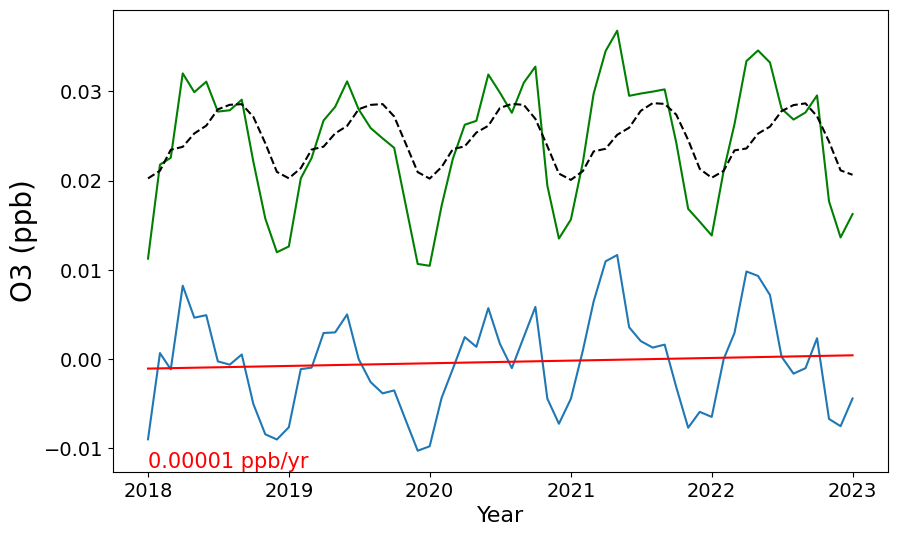

In [32]:
#O3 PLOT OF WEATHER NORMALIZATION

weather_norm_o3 = pd.Series(o3_original - average_predictions_o3)
y_o3 = pd.Series(o3_original)
weather_prediction_o3 = pd.Series(average_predictions_o3)
timeforplot = timeforplot.reset_index(drop=True)

#Create DataFrame for predicted values
o3_df = pd.concat([weather_norm_o3, timeforplot], axis=1)
o3_df.columns = ['O3', 'Date']
o3_df['Date'] = pd.to_datetime(o3_df['Date'])

o3_df['Year'] = o3_df['Date'].dt.year
o3_df['Month'] = o3_df['Date'].dt.month
average_values_1 = o3_df.groupby(['Year', 'Month'])['O3'].mean()

average_values_df1 = average_values.reset_index()

o3_actual_df = pd.concat([y_o3, timeforplot], axis=1)
o3_actual_df.columns = ['O3', 'Date']
o3_actual_df['Date'] = pd.to_datetime(o3_df['Date'])

#Do the same thing for the observed values
o3_df['Year'] = o3_df['Date'].dt.year
o3_df['Month'] = o3_df['Date'].dt.month
average_values = o3_df.groupby(['Year', 'Month'])['O3'].mean()
o3_actual_df['Year'] = o3_actual_df['Date'].dt.year
o3_actual_df['Month'] = o3_actual_df['Date'].dt.month
average_values_2 = o3_actual_df.groupby(['Year', 'Month'])['O3'].mean()

average_values_df1 = average_values_1.reset_index()
average_values_df2 = average_values_2.reset_index()


average_values_df1['Year'] = average_values_df1['Year'].astype(int)
average_values_df1['Month'] = average_values_df1['Month'].astype(int)
average_values_df1['Date'] = pd.to_datetime(average_values_df1['Year'].astype(str) + '-' + average_values_df1['Month'].astype(str))

average_values_df2['Year'] = average_values_df2['Year'].astype(int)
average_values_df2['Month'] = average_values_df2['Month'].astype(int)
average_values_df2['Date'] = pd.to_datetime(average_values_df2['Year'].astype(str) + '-' + average_values_df2['Month'].astype(str))

#Now plotting the meteorological average values
weather_df = pd.concat([weather_prediction_o3, timeforplot], axis=1)
weather_df.columns = ['O3', 'Date']
weather_df['Date'] = pd.to_datetime(o3_df['Date'])
weather_df['Year'] = weather_df['Date'].dt.year
weather_df['Month'] = weather_df['Date'].dt.month
average_values_3 = weather_df.groupby(['Year', 'Month'])['O3'].mean()
average_values_df3 = average_values_3.reset_index()
average_values_df3['Year'] = average_values_df3['Year'].astype(int)
average_values_df3['Month'] = average_values_df3['Month'].astype(int)
average_values_df3['Date'] = pd.to_datetime(average_values_df3['Year'].astype(str) + '-' + average_values_df3['Month'].astype(str))

#Plotting
plt.figure(figsize=(10, 6))
plt.plot(average_values_df1['Date'], average_values_df1['O3'], label="Weather Normalized Vals")
plt.plot(average_values_df2['Date'], average_values_df2['O3'], color='g', label="Observed Values")
plt.plot(average_values_df3['Date'], average_values_df3['O3'], linestyle='dashed', color='k', label="met average vals")

#Theil Sen Regression

x_numeric = pd.to_datetime(average_values_df1['Date']).apply(lambda date: date.toordinal())
y = average_values_df1['O3']

#Calculate the slopes between all pairs of points
slopes = [(y[j] - y[i]) / (x_numeric[j] - x_numeric[i]) 
          for i in range(len(average_values_df1)) 
          for j in range(i+1, len(average_values_df1))]

#Calculate median slope
median_slope = np.median(slopes)
annualized_slope = median_slope * 12
formatted_slope = f"{annualized_slope:.5f}"

#Calculate intercepts for each point
intercepts = [y[i] - median_slope * x_numeric[i] for i in range(len(average_values_df1))]

#Calculate median intercept
median_intercept = np.median(intercepts)

#Plotting
x_range = pd.date_range(start=average_values_df1['Date'].min(), end=average_values_df1['Date'].max(), freq='D')
y_range = median_slope * pd.to_datetime(x_range).map(datetime.toordinal) + median_intercept


plt.plot(x_range, y_range, color='red', label='Theil-Sen Regression Line')

#Format slope and intercept for display (e.g., rounding to 2 decimal places)
formatted_slope = f"{median_slope*12:.5f}"

#Place the text on the plot
#Determine the position for the text
x_position = average_values_df1['Date'].min()
y_position = plt.gca().get_ylim()[0]  # Get the minimum y value of the current axis

# Increase font size of ticks, labels, and title
plt.xticks(fontsize=14)  # Increase x-axis tick font size
plt.yticks(fontsize=14)  # Increase y-axis tick font size
plt.xlabel('Year', fontsize=16)  # Increase x-axis label font size
plt.ylabel('O3 (ppb)', fontsize=20)  # Increase y-axis label font size

plt.text(x_position, y_position, f'{formatted_slope} ppb/yr', fontsize=15, verticalalignment='bottom', color='red')

plt.show()